# **Topic 6 – Introduction to Artificial Neural Networks with Keras**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/drive/1dn0vqXkc-izSpTDpPx3hBZEJk_wgckm5" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1dn0vqXkc-izSpTDpPx3hBZEJk_wgckm5"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ann` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Implementing MLPs with Keras
## Building an Image Classifier Using the Sequential API
### Using Keras to load the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `tf.keras.datasets`. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [6]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


The training set contains 60,000 grayscale images, each 28x28 pixels:

In [7]:
X_train.shape

(55000, 28, 28)

Let's scale the pixel intensities down to the 0-1 range and convert them to floats. We do so by dividing by 255 (because the value goes from 0 to 255). this is good practice when working with Gradient Descent

In [8]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map. As we did with the numbers.

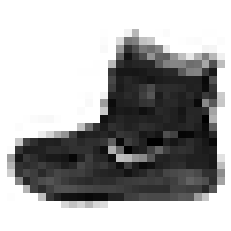

In [9]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [10]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names. I know this because I've checked the glossary of this dataset.

In [11]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is an ankle boot:

In [12]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

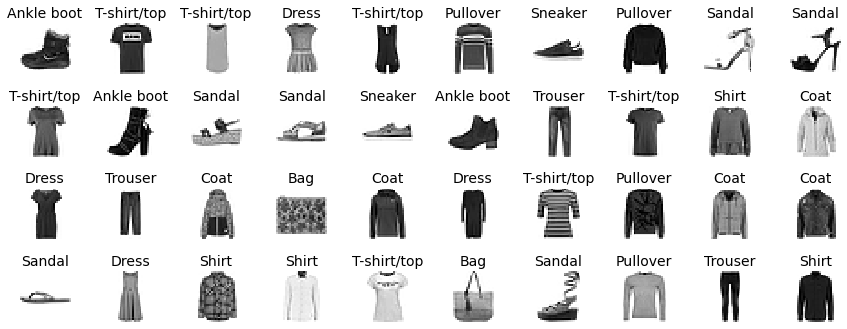

In [13]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

### Creating the model

- First, set TensorFlow’s random seed to make the results reproducible: the random weights of the hidden layers and the output layer will be the same every time you run the notebook.

- The next line creates a Sequential model. This is the simplest kind of Keras model for neural networks that are just composed of a single stack of layers connected sequentially.

- Next, we build the first layer (an Input layer) and add it to the model. We specify the input shape, which doesn’t include the batch size, only the shape of the instances. Keras needs to know the shape of the inputs so it can determine the shape of the connection weight matrix of the first hidden layer.

- Then we add a Flatten layer, which is something specific of this case. Its role is to convert each input image into a 1D array. This layer doesn’t have any parameters; it’s just there to do some simple preprocessing.

- Next we add a Dense hidden layer (dense means all neurons are connected to the following ones) with 300 neurons. It will use the ReLU activation function. Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron).

- Then we add a second Dense hidden layer with 100 neurons, also using the ReLU activation function.

- Finally, we add a Dense output layer with 10 neurons (one per class), using the softmax activation function *because the classes are exclusive*.

In [14]:
tf.random.set_seed(1812)

model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

Instead of adding all the layers one by one, a list of layers can be passed



```
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
```



In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Compiling the model

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

### Training and evaluating the model

***The following cell takes ~5 minutes to run***

Note that we are defning a number of epochs (*passes* for each mini-batch).

It is also noteworthy that, in the cell output, the number below *Epoch X/30* (in this case 1719) is the number of batches in one epoch. This yields 32 instances per batch.

In [17]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.7056 - accuracy: 0.7672 - val_loss: 0.4978 - val_accuracy: 0.8300
Epoch 2/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4830 - accuracy: 0.8343 - val_loss: 0.4381 - val_accuracy: 0.8438
Epoch 3/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4402 - accuracy: 0.8461 - val_loss: 0.4194 - val_accuracy: 0.8508
Epoch 4/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4124 - accuracy: 0.8567 - val_loss: 0.4165 - val_accuracy: 0.8512
Epoch 5/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3928 - accuracy: 0.8618 - val_loss: 0.3949 - val_accuracy: 0.8584
Epoch 6/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3769 - accuracy: 0.8665 - val_loss: 0.3723 - val_accuracy: 0.8662
Epoch 7/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3628 - accuracy: 0.8713 - val_loss: 0.3856 - val_accuracy:

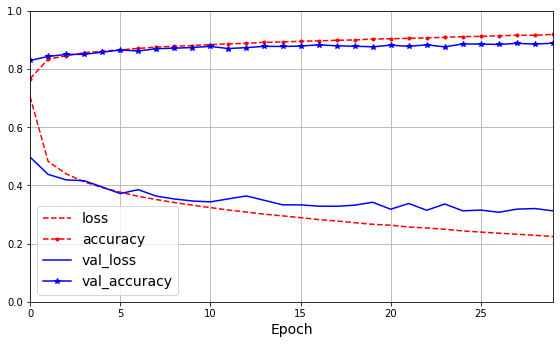

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left") 
save_fig("keras_learning_curves_plot")  
plt.show()

In [19]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3266 - accuracy: 0.8838


[0.32655441761016846, 0.8838000297546387]

### Using the model to make predictions

In [20]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 95ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [23]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [24]:
import numpy as np
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

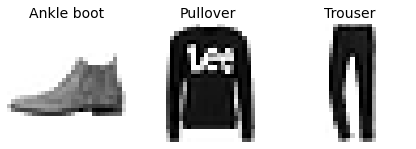

In [25]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## Building a Regression MLP

Let's now use the California housing data set that we used in Topic 2

In [26]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()


In [29]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=1812)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=1812)

Using the sequential API to build, train, evaluate, and use a regression MLP is quite similar to what we did for classification. 

The main differences in the following code example are:

- The output layer has a single neuron (since we only want to predict a single value) and it uses no activation function
- The loss function is the mean squared error
- The metric is the RMSE
- We’re using an Adam optimizer like Scikit-Learn’s MLPRegressor did. 

Moreover, in this example we don’t need a **Flatten** layer, and instead we’re using a **Normalization** layer as the first layer: it does the same thing as Scikit-Learn’s StandardScaler, but it must be fitted to the training data using its `adapt()` method before you call the model’s `fit()` method. In other words, you no to explicitly normalize before fitting.

Evertything is done (preparation, compilation, fit, prediction) in the next chunk of code.

In [31]:
tf.random.set_seed(1812)

norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])

model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

norm_layer.adapt(X_train)

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 3s 4ms/step - loss: 0.8262 - root_mean_squared_error: 0.9089 - val_loss: 0.4088 - val_root_mean_squared_error: 0.6393
Epoch 2/20
363/363 [==============================] - 3s 9ms/step - loss: 0.4032 - root_mean_squared_error: 0.6350 - val_loss: 0.3847 - val_root_mean_squared_error: 0.6203
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3676 - root_mean_squared_error: 0.6063 - val_loss: 0.3589 - val_root_mean_squared_error: 0.5991
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3553 - root_mean_squared_error: 0.5961 - val_loss: 0.3317 - val_root_mean_squared_error: 0.5759
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3497 - root_mean_squared_error: 0.5914 - val_loss: 0.3720 - val_root_mean_squared_error: 0.6099
Epoch 6/20
363/363 [==============================] - 2s 4ms/step - loss: 0.3396 - root_mean_squared_error: 0.5827 - val_loss: 0.3255 - val_

In [32]:
rmse_test

0.533794105052948

In [33]:
y_pred

array([[1.4233779],
       [2.8128796],
       [2.0635474]], dtype=float32)